# Web Mining Project Midterm Project
## ICO Data Collection and Analysis

***Prof: Dr. Rong Liu*** \\
***TA: Jujun Huang*** \\
***Agamdeep Chopra, Arnold Yanga, Ilesh Sharda*** \\
***Group 4*** \\


In [ ]:
# Install dependencies

!pip install slate3k
!pip install asyncio
!pip install aiohttp

In [ ]:
import time
import pandas as pd
import numpy as np 
from pathlib import Path
import slate3k as slate
import asyncio
import aiohttp
import seaborn as sns
import matplotlib.pyplot as plt

### Data Collection
The dataset used for this project is the ***Token Offerings Research Database (TORD)*** collected by P.P. Momtaz. It is noted by the author that the dataset, while comprehensive, is continuously updated and in turn suffers from missing data and survivorship bias. With regard to TORD, our project focuses on ICO white paper text data along with key ICO features. 

Link: [TORD Dataset](https://www.paulmomtaz.com/data/tord)

### Understanding ICO features listed in TORD
The scope of this project requires us to utilize text analysis in parallel with key ICO features in order to create a valid risk assessment model for future and/or current coin offerings. Below is a brief description of some of the relevant ICO features explored for this project

***Key Features***
* **ICO Price**: The token price in USD during launch period
* **Pre ICO Price**: The token price during Pre-ICO phase
* **Platform**: Blockchain platform used for token distribution
* **Country**: The country the ICO team is based in
* **Soft Cap**: The minimum defined limit for hte collection of funds specified by a project's team for fundraising
* **Hard Cap**: The maximum possible funding that a team is looking to collect
* **Tokens For Sale**: The total amount of tokens available for sale
* **Whitelist**: Whether or not an index of participants in a token presale is available
* **KYC Regulations**: Requirement for a project to verify identification and keep records on the essential facts of each customer/investor
* **Pre-ICO Bonus**: Whether or not a ICO project rewards individuals who purchase a set amount of tokens during the Pre-ICO phase
* **Bounty Program**: Whether or not a program is in place to reward individuals who perform specific tasks to aid in the promotion of the project
* **MVP**: (Minimum Viable Product) Whether or not a project releases a "proof of concept" with just enough features to be usable for early customers who can then provide feedback to improve product design

### Initial Cleaning and Generating Insights Using IBM's Watson Studio

For this project, we leverage IBM's Watson Studio and Cloud Pak services to perform initial data cleaning. Watson Studio is unique as it provides users with a GUI that allows users to clean/impute/filter data at the click of a button. The simplicity of Watson Studio's data pipeline allowed us to focus more on extracting key insights rather than manually cleaning the data. In turn, the initial TORD dataset was reduced to a sample size of 683 after the first round of cleaning. 

We note that rows that contained a high volume of missing values were dropped, such as "raised_USD" and "sold_tokens". While these features may seem useful, the impracticality of imputing or manually revising these features outweighed the utility it may serve in the model building process. Once completed, we used Watson Studio to assemble an interactive dashboard to visualize the relationship between categorical ICO features.

Link to interactive dashboard: [IBM ICO Dashboard](https://https://dataplatform.cloud.ibm.com/dashboards/db575f75-8db5-467c-b9eb-bd67d8b2b14a/view/0e67e02003af39ee10fdb5e4079b25577a64775ce0bbd55782867b490b632297a86e4098c87e4359d3145065f2b9465fce)

![Dashboard](https://github.com/AgamChopra/bia660-team4-spring-2021/blob/main/ibm-expo-screenshot1.PNG?raw=true)

In this section, we will use pandas to first understand our data. Then we will clean the data to filter out a reasonable number of outliers and drop any remaining missing values. We will then extract additional features such as ICO period from the data. Finally, we then create visualizations of the relationships between the features in order to gain valuable insights with respect to the ICO market.


In [ ]:
url = 'https://raw.githubusercontent.com/AgamChopra/bia660-team4-spring-2021/main/ICOs-V1_cleaned.csv'
df = pd.read_csv(url)
df.head()

,name,country,ico_start,ico_end,price_usd,soft_cap_usd,hard_cap_usd,distributed_in_ico,token_for_sale,whitelist,kyc,bonus,restricted_areas,bounty,mvp,pre_ico_start,pre_ico_end,pre_ico_price_usd,platform,accepting,link_provided
0,DenchMusic,Netherlands,2018-12-01,2018-12-15,0.0857,568182,39772740,0.85,4.250000e+08,Yes,Yes,Available,USA,Available,Available,2018-11-21,2018-11-30,0.036215,Ethereum,ETH,Yes
1,Eristica,Singapore,2017-12-07,2018-02-07,0.0200,1000000,10000000,0.68,1.569055e+08,No,Yes,Unavailable,"USA, China, Canada",Unavailable,Unavailable,2017-09-01,2017-10-01,0.020000,Ethereum,BTC/ETH/LTC/BCH,Yes
2,Lunch Money,USA,2018-08-05,2018-09-05,1.0000,1000000,40000000,0.16,4.000000e+07,Not Specified,Not Specified,Unavailable,None,Unavailable,Unavailable,2018-07-05,2018-08-05,0.800000,Ethereum,ETH,Yes
3,Okschain,Estonia,2019-12-26,2020-02-12,0.0010,4725000,12090000,0.78,1.209000e+10,No,Yes,Unavailable,USA,Available,Available,2019-11-25,2019-12-25,0.001000,Ethereum,"ETH, BTC, USDT, USD, EUR",Yes
4,Shard,UK,2018-03-26,2018-04-23,0.6113,963821,8031849,0.80,2.000000e+07,No,No,Unavailable,None,Available,Unavailable,2018-03-17,2018-03-24,0.265334,Scrypt,"BTC, ETH, LTC, XRP",Yes


In [ ]:
df.describe()

,price_usd,soft_cap_usd,hard_cap_usd,distributed_in_ico,token_for_sale,pre_ico_price_usd
count,683.000000,6.830000e+02,6.830000e+02,683.000000,6.830000e+02,6.830000e+02
mean,441.544111,8.858734e+06,4.791958e+07,0.550876,1.253820e+09,2.491732e+04
std,11479.107053,7.176197e+07,1.423831e+08,0.194925,4.545596e+09,6.392824e+05
min,0.000012,0.000000e+00,1.137940e+05,0.010000,6.000000e+01,4.665400e-05
25%,0.043000,1.000000e+06,9.080194e+06,0.445000,5.000000e+07,3.100000e-02
50%,0.114000,2.169335e+06,1.840555e+07,0.550000,2.000000e+08,9.473367e-02
75%,0.485000,5.000000e+06,3.427500e+07,0.700000,5.150000e+08,3.348394e-01
max,300000.000000,1.800000e+09,2.100000e+09,1.000000,5.000000e+10,1.670525e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                683 non-null    object 
 1   country             680 non-null    object 
 2   ico_start           683 non-null    object 
 3   ico_end             683 non-null    object 
 4   price_usd           683 non-null    float64
 5   soft_cap_usd        683 non-null    int64  
 6   hard_cap_usd        683 non-null    int64  
 7   distributed_in_ico  683 non-null    float64
 8   token_for_sale      683 non-null    float64
 9   whitelist           683 non-null    object 
 10  kyc                 683 non-null    object 
 11  bonus               683 non-null    object 
 12  restricted_areas    683 non-null    object 
 13  bounty              683 non-null    object 
 14  mvp                 683 non-null    object 
 15  pre_ico_start       683 non-null    object 
 16  pre_ico_

## Data Cleaning and Feature Engineering

After reviewing our dataset, there are still adjustments that can be made beyond to clean and further strengthen our dataset. We utilize the pythons datetime features to extract the ICO and Pre-ICO phase lengths and dump the columns containing the respective dates. Furthermore, we convert the restricted areas column to display the number of restricted countries rather than the names of the countries. These changes will make our data more compatible for modelling in the future

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def string_to_datetime(df, columns):
  for i in columns:
    df[i] = pd.to_datetime(df[i], format='%Y-%m-%d')
  return df

# Convert ICO & Pre ICO dates to datetime format

datetime_cols = ['ico_start', 'ico_end', 'pre_ico_start', 'pre_ico_end']
df = string_to_datetime(df, datetime_cols)
df['ico_period'] = df.apply(lambda x: (x.ico_end - x.ico_start).days, axis = 1)
df['pre_ico_period'] = df.apply(lambda x: (x.pre_ico_end - x.pre_ico_start).days, axis = 1)

# Drop all rows with inconsistent dates (i.e. negative periods)

df = df[(df['ico_period'] >= 0) & (df['pre_ico_period'] >= 0)]

# Convert restricted areas from string to int based on the number of restricted areas

tokenize = CountVectorizer().build_tokenizer()

df['restricted_areas'] = df.restricted_areas.apply(tokenize)
df['restricted_areas'] = df.restricted_areas.apply(len)

# Drop the datetime columns along with any remaining rows with missing values
df = df.drop(columns=datetime_cols)
df = df.dropna()

## Exploratory Data Analysis

In this section, we utilize standard methods from the pandas and matplotlib libraries to visualize our data

In [ ]:
df.describe()

,price_usd,soft_cap_usd,hard_cap_usd,distributed_in_ico,token_for_sale,restricted_areas,pre_ico_price_usd,ico_period,pre_ico_period
count,651.000000,6.510000e+02,6.510000e+02,651.000000,6.510000e+02,651.000000,651.000000,651.000000,651.000000
mean,2.037733,9.122088e+06,4.908628e+07,0.551758,1.287163e+09,3.537634,0.631181,75.428571,46.737327
std,17.069404,7.349313e+07,1.456788e+08,0.195645,4.647956e+09,7.332733,2.781498,78.656482,51.715555
min,0.000012,0.000000e+00,1.141600e+05,0.010000,6.000000e+01,1.000000,0.000047,0.000000,1.000000
25%,0.040750,1.000000e+06,9.004004e+06,0.445000,5.200000e+07,1.000000,0.030000,30.000000,18.000000
50%,0.110717,2.169335e+06,1.815672e+07,0.550000,2.000000e+08,1.000000,0.090100,55.000000,30.000000
75%,0.450000,5.000000e+06,3.500000e+07,0.700000,5.250000e+08,3.000000,0.300000,91.000000,58.000000
max,295.340000,1.800000e+09,2.100000e+09,1.000000,5.000000e+10,80.000000,29.534100,671.000000,397.000000


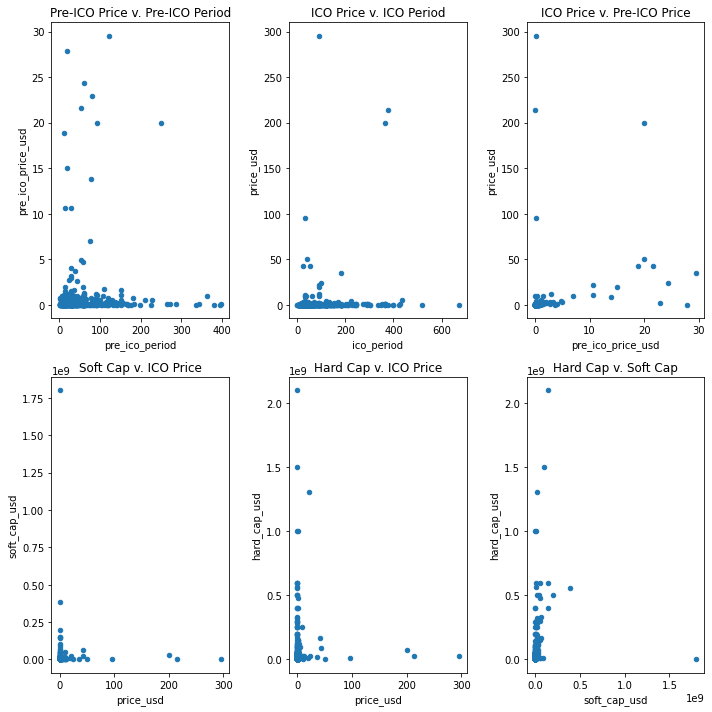

In [ ]:
df = df.loc[df.pre_ico_price_usd < 100]
df = df.loc[(df.ico_period < 1000)&(df.price_usd <1000)]

fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (10,10))
df.plot.scatter(x = 'pre_ico_period', y = 'pre_ico_price_usd', ax = axes[0,0])
df.plot.scatter(x = 'ico_period', y = 'price_usd', ax = axes[0,1])
df.plot.scatter(x = 'pre_ico_price_usd', y = 'price_usd', ax = axes[0,2])
df.plot.scatter(x = 'price_usd', y = 'soft_cap_usd', ax = axes[1,0])
df.plot.scatter(x = 'price_usd', y = 'hard_cap_usd', ax = axes[1,1])
df.plot.scatter(x = 'soft_cap_usd', y = 'hard_cap_usd', ax = axes[1,2])

axes[0,0].set_title('Pre-ICO Price v. Pre-ICO Period')
axes[0,1].set_title('ICO Price v. ICO Period')
axes[0,2].set_title('ICO Price v. Pre-ICO Price')
axes[1,0].set_title('Soft Cap v. ICO Price')
axes[1,1].set_title('Hard Cap v. ICO Price')
axes[1,2].set_title('Hard Cap v. Soft Cap')

plt.tight_layout()
plt.show()

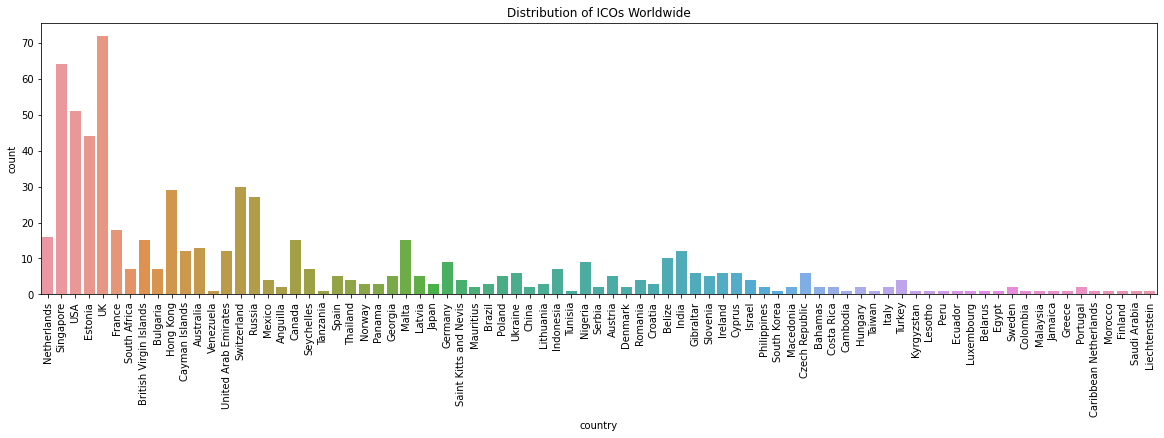

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'country', data = df)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.title('Distribution of ICOs Worldwide')
plt.show()

***Generate a correlation heatmap for the numerical data***

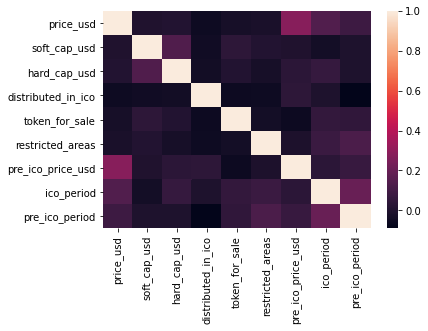

In [ ]:
sns.heatmap(df.corr())

In [ ]:
df 

,name,country,price_usd,soft_cap_usd,hard_cap_usd,distributed_in_ico,token_for_sale,whitelist,kyc,bonus,restricted_areas,bounty,mvp,pre_ico_price_usd,platform,accepting,link_provided,ico_period,pre_ico_period
0,DenchMusic,Netherlands,0.0857,568182,39772740,0.85,4.250000e+08,Yes,Yes,Available,1,Available,Available,0.036215,Ethereum,ETH,Yes,14,9
1,Eristica,Singapore,0.0200,1000000,10000000,0.68,1.569055e+08,No,Yes,Unavailable,3,Unavailable,Unavailable,0.020000,Ethereum,BTC/ETH/LTC/BCH,Yes,62,30
2,Lunch Money,USA,1.0000,1000000,40000000,0.16,4.000000e+07,Not Specified,Not Specified,Unavailable,1,Unavailable,Unavailable,0.800000,Ethereum,ETH,Yes,31,31
3,Okschain,Estonia,0.0010,4725000,12090000,0.78,1.209000e+10,No,Yes,Unavailable,1,Available,Available,0.001000,Ethereum,"ETH, BTC, USDT, USD, EUR",Yes,48,30
4,Shard,UK,0.6113,963821,8031849,0.80,2.000000e+07,No,No,Unavailable,1,Available,Unavailable,0.265334,Scrypt,"BTC, ETH, LTC, XRP",Yes,28,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,Hazeian,UK,0.3000,1500000,39000000,0.65,1.300000e+08,No,Yes,Unavailable,1,Unavailable,Unavailable,0.240000,Ethereum,ETH,Yes,28,6
679,Bountie,Singapore,0.0314,434365,4343659,0.65,2.000000e+08,Yes,Yes,Unavailable,1,Unavailable,Unavailable,0.029400,Ethereum,ETH,Yes,11,34
680,Monster Byte,Canada,0.0750,2250000,15000000,0.80,2.000000e+08,No,No,Unavailable,2,Unavailable,Unavailable,0.075000,Waves,"BTC, EOS, TRX, LTC, ETH",Yes,20,12
681,PGF500,Switzerland,0.1137,6711108,24607396,0.80,2.272000e+08,No,Yes,Unavailable,2,Unavailable,Available,0.113684,Ethereum,ETH,Yes,172,6


In [ ]:
from google.colab import files

df.to_csv('ICOfeatures_clean.csv')
files.download('ICOfeatures_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Collecting Text Data
First, we download and import the ICO-V1 excel spreadsheet into Python as a dataframe. From there we examine the white_paper_links column. The script below compiles each link included in the database, downloads the link and extracts the corresponding text data. The name of each ICO and its respective white paper text data is returned.



***Asynchronous Programming***

Due to the high volume of documents, runtime can take up to over 24 hours. Additionally, many links in the database are either broken or contain encrypted documents, which can provide errors and increase runtime. To combat this effect, we implement asynchronous programming using the async IO (asyncio) package in python. Asyncio utilizes "concurrent multitasking" to combat wait times for tasks through coroutines. In short, coroutines have the ability to suspend its execution before returning and indirectly pass control to other coroutines for a given time. We utilize this feature to mitigate the effects of broken links and complex pdf files by continuously switching between tasks. This is to say that multiple calls of a coroutine need not wait for each other to complete in succession. This methodology can reduce the processing time of files in half. By implementing asyncio into our code, the time it takes to import and process the text data is reduced from a scale of days to hours.

In [ ]:
''' 
Note: The ayncio package may generate an event loop error for certain IDE's but runs perfectly fine on Pycharm 
      The script below is included to showcase our pdf scraping methodology
'''
loop = asyncio.get_event_loop()

async def get_pdf(url):
    async with aiohttp.ClientSession(loop=loop) as session:
        async with session.get(url) as response:
            return await response.content.read()


async def extract_data(pdf, name):
    try:
        with open(pdf, 'rb') as f:
            return slate.PDF(f)
    except Exception:
        print(f'Failed to get PDF content for {name}')
    return ''


async def send_request(url, name):
    extracted_pdf = ''
    try:
        filename = name.replace(' ', '_') + '.pdf'
        file = await get_pdf(url)
        pdf = Path(filename)
        pdf.write_bytes(file)
        extracted_pdf = await extract_data(pdf, name)
        pdf.unlink()  # Removes file to save storage
    except Exception:
        print(f'Failed to download data from {url}')

    return extracted_pdf


async def pdf_to_str(data):
    result = []
    for index, row in data.iterrows():
        name = row['name']
        link = row['link_white_paper']
        print(f'Sending request for {name}')
        start_time = time.perf_counter()
        result.append(await send_request(link, name))
        print(f'Successfully completed request for {name} in {time.perf_counter() - start_time}')
    data['Text'] = result
    return data


if __name__ == "__main__":
    start = time.perf_counter()
    df = pd.read_excel('/Users/ArnoldYanga/Downloads/ICOs-V1.xlsx')
    links = df[df['link_white_paper'].notnull()][['name', 'link_white_paper']]
    result = loop.run_until_complete(pdf_to_str(links))
    print(f'Completed entire process in {time.perf_counter() - start}')
    result.to_csv('/Users/ArnoldYanga/Desktop/Dataset/ICO3.csv')

## Text Analysis
After importing the text data, we provide a script that cleans,tokenizes, and calculates the tf-idf values for each document in our corpus.
The final outputs give us 3 arrays namely Title, tok-sens, and tf-idf. Title contains the titles of each whitepaper and text contains the corrosponding text in the extracted whitepaper. tok-sen is an array that contains tokenized text corrosponding to text. Tf-idf contains the tf-idf matrix of all the tokens in tok-sens.

In [ ]:
#Remark: import the following to move forward...
#import sys                 #optional to save model weights
#sys.path.append("PATH")    # ''
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_labels(file_path):
    return pd.read_csv(r'%s'%(file_path)).values[:,1:]

def load_data(file_path):  
    return pd.read_csv (r'%s'%(file_path)).values[:,1:]
    
def processed_data(data):
    return data[:,0], [sents.lower() for sents in data[:,1]]

def tokenize_sen(sen):
    stop_words = set(stopwords.words("english"))
    return [word for word in [''.join(e for e in string if e.isalnum()) for string in [x.replace('\\n','') for x in nltk.word_tokenize(sen)]] if word not in stop_words and word != '']
'''
def token_count(sen):
    return {token:sen.count(token) for token in set(sen)}

def tf_idf(docs):
    docs_tokens={idx:token_count(doc) for idx,doc in enumerate(docs)}
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
    dtm = dtm.sort_index(axis = 0)        
    tf=dtm.values
    doc_len=tf.sum(axis=1, keepdims=True)
    tf=np.divide(tf, doc_len)
    df=np.where(tf>0,1,0)
    smoothed_idf=np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1    
    smoothed_tf_idf=tf*smoothed_idf
    return smoothed_tf_idf
'''
title,text = processed_data(load_data(file_path = "https://raw.githubusercontent.com/AgamChopra/bia660-team4-spring-2021/main/ICOtext.csv"))
labels = load_data(file_path='https://raw.githubusercontent.com/AgamChopra/bia660-team4-spring-2021/main/label.csv')
y = torch.Tensor(labels.ravel())
tok_sens = [tokenize_sen(sen) for sen in text]
'''
tfidf = tf_idf(tok_sens)
print(tfidf)
'''

NameError: ignored

# Information Content Analysis

In order to generate standard and informative content scores, we first perform an unsupervised learning task to partition the data into industry clusters. We then partition the data based on how many ICOs were released 90 days before the selected ICO was released. From there we generate the average norm vector terms for industry and recent ICOs. We then run a multiple regression model on each document to calculate the standard and informative scores

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.cm as cm  
from sklearn import mixture
import pandas as pd
!pip install wordninja
import wordninja
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, random_state=1234, batch_size = 65, n_init=35).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

def plot_pca(data, labels):
    
    pca = PCA(n_components=2).fit_transform(data.todense())
    colors = ['purple', 'red', 'orange', 'green', 'yellow', 'cyan', 'mediumpurple']
    #f, ax = plt.subplots(1, 2, figsize=(14, 6))

    plt.figure(figsize = (8,6))
    sns.scatterplot(x=pca[:,0], y=pca[:,1], hue = labels, palette = colors)
    plt.title('PCA Plot of Labels (MiniBatch KMeans, k = 7)')
    plt.show()

def string_to_datetime(df, columns):
    for i in columns:
      df[i] = pd.to_datetime(df[i], format='%Y-%m-%d')
    return df

def isalpha(mylist):
    return [item for item in mylist if item.isalpha()]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
icoText = pd.read_csv('ICOtext_info.csv')

title = icoText['name']
text = [sents.lower() for sents in icoText['Text']]
tok_sens = [tokenize_sen(sen) for sen in text]

# Remove numbers from the list of tokens
token_list = []
for doc in tok_sens:
  token_list.append(isalpha(doc))

corpus = []

for doc in token_list:
  tok = []
  for token in doc:
    split = wordninja.split(token)
    tok.extend(split)
  corpus.append(tok)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

corpus_lemmatized = []
for doc in corpus:
  doc_tokens = []
  for word in doc:
    lemma = wordnet_lemmatizer.lemmatize(word, pos = 'v')
    doc_tokens.append(lemma)
  corpus_lemmatized.append(doc_tokens)

corpus_cleaned = []
for doc in corpus_lemmatized:
  corpus_cleaned.append(' '.join(doc))

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters


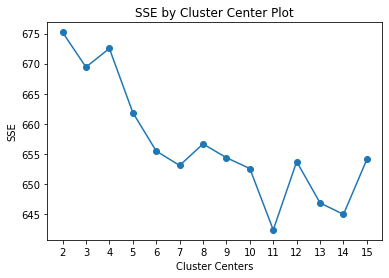

In [ ]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words='english', min_df = 5) 
tfidf=tfidf_vectorizer.fit_transform(corpus_cleaned)

find_optimal_clusters(tfidf, 15)

## MiniBatch KMeans Clustering

In [ ]:
mbkm = MiniBatchKMeans(n_clusters=7, random_state=1234, batch_size = 65, n_init=35)
clusters = mbkm.fit_predict(tfidf)

In [ ]:
plot_pca(tfidf, clusters)

In [ ]:
tsne = TSNE(random_state=1234)

X_tsne = tsne.fit_transform(tfidf.todense())

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE Plot of Labels (MiniBatch KMeans, k = 7)')

silhouette_score(tfidf, clusters)

## Gaussian Mixture Model

In [ ]:
lowest_bic = np.infty   
best_gmm = None

n_components_range = range(5,9) 

cv_types = ['spherical', 'tied', 'diag']  # covariance type
for cv_type in cv_types:
    
    for n_components in n_components_range:
        
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=42)
        gmm.fit(tfidf.toarray())
        
        bic = gmm.bic(tfidf.toarray())  # get Model BIC
        
        if bic < lowest_bic:  # save the model with lowest BIC so far
            lowest_bic = bic
            best_gmm = gmm

In [ ]:
clusters_gmm = best_gmm.predict(tfidf.toarray())

pca = PCA(n_components=2)
X = pca.fit_transform(tfidf.toarray())

plt.figure()
sns.scatterplot(x=X[:,0], y=X[:,1], hue = clusters_gmm, palette= ['red', 'green', 'blue', 'orange', 'purple', 'mediumpurple','cyan', 'pink'])
plt.title('PCA Plot of Labels (Gaussian MM, n = 8)')
plt.show()

In [ ]:
icoText['cluster']=clusters

tfidf_array = tfidf.toarray()

norm_ind = []
for i in range(len(tfidf_array)):
  clust = icoText.loc[i,:]['cluster']
  setK = []
  for j in icoText[icoText['cluster']==clust].index:
    setK.append(tfidf_array[j])
  avg = [sum(i)/len(setK) for i in zip(*setK)]
  norm_ind.append(avg)

In [ ]:
datetime_cols = ['ico_start', 'ico_end']
df = string_to_datetime(icoText, datetime_cols)
test_sample = df.ico_start.values

recent_ico_id = []
for j, date in enumerate(test_sample):
  store = []
  for i, date in enumerate(test_sample):
    delta = (test_sample[j] - date)/ np.timedelta64(1, 'D')
    if delta < 60 and delta >= 0:
      store.append(i)
  recent_ico_id.append(store)

In [ ]:
ico_overlap = [len(element) for element in recent_ico_id]

plt.style.use('seaborn')
plt.figure()
plt.hist(ico_overlap)
plt.xlabel('Number of ICOs')
plt.title('Distribution of ICOs Released in the Same Period')
plt.show()

In [ ]:
norm_time = []

for i in range(len(test_sample)):
  indexes = recent_ico_id[i]
  set_time = []
  for j in indexes:
    set_time.append(tfidf_array[j])
  avg = [sum(i)/len(set_time) for i in zip(*set_time)]
  norm_time.append(avg)

In [ ]:
from sklearn import linear_model
import statsmodels.api as sm

# Regression
# Target: tfidf vector for ICO i
# Features: norm_time, norm_ind

standard_content = []
informative_content = []

for i in range(len(tfidf_array)):
  feature_dict = {'norm_ind': norm_ind[i], 'norm_time': norm_time[i], 'tfidf': tfidf_array[i]}
  df = pd.DataFrame(feature_dict)

  X = df[['norm_ind','norm_time']]
  X = sm.add_constant(X)
  y = df[['tfidf']]

  model = sm.OLS(y, X).fit()

  coefs = model.params 
  standard_content.append(coefs[1] + coefs[2])
  informative_content.append(model.ssr)

In [ ]:
from datetime import datetime

icoText['standard_content']=standard_content
icoText['informative_content'] = informative_content

plt.figure()
plt.scatter(icoText['ico_start'], icoText['informative_content'], alpha = 0.45, label = 'Infromative')
plt.scatter(icoText['ico_start'], icoText['standard_content'], color= 'red', alpha = 0.45, label = 'Standard')
plt.xlim(
  datetime(2016, 1, 10, 17, 00),
  datetime(2021, 10, 10, 19, 00)
  )
plt.ylabel('Score')
plt.title('Content Scores Based on ICO Start Date')
plt.legend()
plt.show()

In [ ]:
plt.figure()
icoText.plot('standard_content', 'informative_content', kind = 'scatter')
plt.xlabel('Standard Content')
plt.ylabel('Informative Content')
plt.title('Standard v. Informative Content')
plt.show()

# Word Embeddings
To train deep neural networks, we need a way to encode the words in the corpus in a representation that the ANN “understand” and can extract as much meaningful information from. One approach would be one hot encoding but given our dataset, that would be a very memory inefficient approach. Another alternative would be to train a shallow neural network to map each word to a vector space. The idea is that words with similar context will be mapped to vectors with similar value. The computational cost required to train such transformation is immense as, due to the time constraints, we only train the model for 20 epochs on a fraction of our dataset. For this project, we believe that these constraints should not invalidate any preliminary results from this analysis. We plan to make our code more efficient and train for longer epochs over the entire dataset in future. 
We utilize PyTorch for creating a word embedding model. The first step was to give each word some context for the model to learn. This was done by supplying each word with 2 words preceding it and 2 words in its succession as context. We shall refer to this tuple as the word-context ngram. The next step was to assign each word a unique key/index to lookup its vector implementation after training the embedding model. We created a NGramLanguageModular model as described in the PyTorch documentation to generate our word embeddings.
After training this model with the corpus subset, we created a few helper functions that translate the corpus information to our models in a readable vector format. This was done by initializing a torch tensor with zero values and shape (num_docs, vector_length, 5000). Here 5000 is an arbitrary number to fix the size of our training sample for simplicity. This length was chosen by dividing the total words in the subset by the number of documents and rounding to the nearest 1000. As one might expect, the actual document length might be lower or higher than this, hence the zero initialization. The words were then converted to vector formats using the trained embeddings and copied over to this tensor. A few more helper functions then restructured this tensor for the models they were used in.
<div>
<img src="https://github.com/AgamChopra/bia660-team4-spring-2021/blob/main/embeds.png?raw=true" width="500"/>
</div>

In [ ]:
# Embeddings:
# Setup
CONTEXT_SIZE = 4
EMBEDDING_DIM = 8
test_sentence = []
[[test_sentence.append(word) for word in tok_sens[i]]for i in range(6)] # First 6 documents
grams = [[([test_sentence[i], test_sentence[i + 1], test_sentence[i + 3], test_sentence[i + 4]], test_sentence[i + 2]) for i in range(len(tok_sens[j]) - 5)] for j in range(6)]
ngrams = []
[[ngrams.append(i) for i in j]for j in grams]
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

# Definition
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
# call the model
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)

#Load the pre-trained embeddings. Please upload this file https://github.com/AgamChopra/bia660-team4-spring-2021/blob/main/embedding.pth?raw=true to the root folder for each new runtime!
model.load_state_dict(torch.load(r'embedding.pth')) # Load pretrained model parameters

<All keys matched successfully>

epoch: 0 loss: 170438.60052322273
epoch: 1 loss: 69899.11698590114
epoch: 2 loss: 37840.01011921357
epoch: 3 loss: 23617.143896563313
epoch: 4 loss: 16966.81157342598
epoch: 5 loss: 13573.319392862028
epoch: 6 loss: 11221.917590526997
epoch: 7 loss: 9499.018676007487
epoch: 8 loss: 7927.87011069382
epoch: 9 loss: 6514.6644360283435
epoch: 10 loss: 5354.906239901997
epoch: 11 loss: 4338.64870766671
epoch: 12 loss: 3543.5498992590365
epoch: 13 loss: 2833.430770130724
epoch: 14 loss: 2336.921052243845
epoch: 15 loss: 1793.4915699043256
epoch: 16 loss: 1475.4869387639221
epoch: 17 loss: 1105.090452682242
epoch: 18 loss: 811.8599547897295
epoch: 19 loss: 616.8120525982439


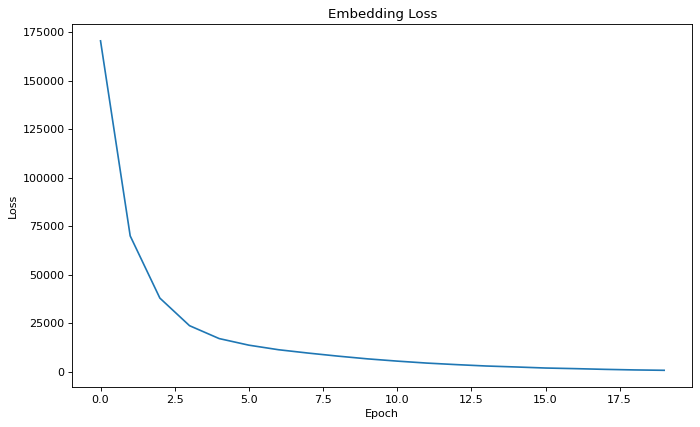

In [ ]:
# Train Embeddings:
losses = []
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(20):
    total_loss = 0
    for context, target in ngrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 1 == 0:
        print('epoch:', epoch,'loss:', total_loss)
    losses.append(total_loss)
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Embedding Loss')
plt.show()


In [ ]:
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model.state_dict(),r'embedding.pth')
files.download('embedding.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Word to Vector helper functions
Helper functions to extract words in vector format and convert them to the input formats of the models discussed below.

In [ ]:
# Extract vectors:
# definitions
def extract_docs(x, doc_number = 6, max_words=5000): # x = tok_sens #looks up trained vector representation of words in the range of docs provided.
    docs = [x[i][:max_words] for i in range(doc_number)]
    docx = [[model.embeddings.weight[word_to_ix[word]]for word in doc]for doc in docs]
    xx = [[j.detach() for j in i] for i in docx]
    return xx
def data_vectorizer(xx, num_examples, embd_dim, max_words): # converts data into readable format for the models.
    x = torch.zeros(num_examples, embd_dim, max_words)
    for i in range(num_examples):
        for j in range(len(xx[i])):
                x[i,:,j] = xx[i][j]
    return(x)
def lstm_data_reshape(x): # (6, 8, 5000) -> (8,6,5000)
    temp = torch.zeros(8,6,5000)
    for i in range(6):
        for j in range(5000):
            temp[:,i,j] = x[i,:,j]
    return temp
def feedforward_data_reshape(x): # (6, 8, 5000) -> (6,8*5000)
    temp = torch.zeros(6,40000)
    for i in range(6):
        l = 0
        for j in range(8):
            for k in range(5000):
                temp[i][l] = x[i][j][k]
                l += 1
    return temp

# create trainable embeddings
xx = extract_docs(tok_sens, 6, 5000)
x = data_vectorizer(xx, 6, EMBEDDING_DIM, 5000)

# Perceptron Model
The perceptron is probably the simplest Feedforward neural network. It was set up as a benchmark model but gave decent results in the prototyping phase, so we decided to include it in this report as a benchmark to compare our model with. Our Perceptron consists of a singular “neuron” that takes the input per document as a flattened 1d array and uses sigmoid nonlinearity to predict a classification for the document. 
The model was coded to have a train, evaluate, save, and load functions to reduce complexity for the end user. The model utilizes ADAM optimization and BCE Loss (Log loss for binary classification) to update its parameters during backpropagation.
<div>
<img src="https://github.com/AgamChopra/bia660-team4-spring-2021/blob/main/perceptron.png?raw=true" width="500"/>
</div>

In [ ]:
#perceptron
class classifier_perceptron(nn.Module):
    def __init__(self, in_size, out_size):#8,1
        super(classifier_perceptron, self).__init__()
        self.f = nn.Sequential(nn.Linear(in_size,out_size),nn.Sigmoid())

    def forward(self, x):
        y = self.f(x)
        return y
    
class perceptron_model():
    def __init__(self):
        self.model = classifier_perceptron(40000,1)
            
    def train(self,x, y, epochs = 100, lr = 0.001): # x and y are in torch tensor format
        # prediction b4 training
        x = feedforward_data_reshape(x)
        self.model.eval()
        y_pred = self.model(x)
        print(y_pred)
        self.model.train()
        loss_list = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr = lr, weight_decay= lr/100)
        criterion = torch.nn.BCELoss()
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward pass
            y_pred = self.model(x)
            loss = criterion(y_pred.squeeze(), torch.reshape(y,[len(y_pred.squeeze())]).float())
            loss_list.append(loss)
            if epoch%10 == 0:
                print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
            # Backward pass
            loss.backward()
            optimizer.step()
        return loss_list
    
    def evaluate(self, x):
        self.model.eval()
        x = feedforward_data_reshape(x)
        y_pred = self.model(x)
        return y_pred
    
    def save_model(self):
        torch.save(self.model.state_dict(), 'FF.pth')
    
    def load_model(self):
        self.model.load_state_dict(torch.load('FF.pth'))

# CNN Model
The CNN (Convolutional Neural Network) model utilizes concepts from computer vison and applies them to the word vector document implementation. By using filters and windows, we can drastically reduce computational cost and parameter size while achieving similar or better performance as traditional dense neural nets. CNNs are a class of sparce networks since they share parameters per learnable window. 
The model was coded to have a train, evaluate, save, and load functions to reduce complexity for the end user. The model utilizes ADAM optimization and BCE Loss (Log loss for binary classification) to update its parameters during backpropagation.
<div>
<img src="https://github.com/AgamChopra/bia660-team4-spring-2021/blob/main/conv.png?raw=true" width="1000"/>
</div>

In [ ]:
#CNN:
def conv_block(in_c, out_c, ker, std, kp, sp):
    out = nn.Sequential(nn.Conv1d(in_channels=in_c, out_channels=out_c, kernel_size=ker, stride=std),nn.BatchNorm1d(out_c),nn.ReLU(inplace=True),nn.MaxPool1d(kernel_size=kp, stride=sp))
    return out

def conv1_block(in_c, out_c):
    out = nn.Sequential(nn.Conv1d(in_channels=in_c, out_channels=out_c, kernel_size=3, stride=1),nn.BatchNorm1d(out_c),nn.Sigmoid())#,nn.Softmax(dim=1))
    return out

class classifier_conv(nn.Module):
    def __init__(self):
        super(classifier_conv, self).__init__()
        self.f1 = conv_block(8,16,8,2,9,2)
        self.f2 = conv_block(16,32,9,2,9,5)
        self.f3 = conv_block(32,64,4,2,4,3)
        self.f4 = conv_block(64,128,6,3,3,1)
        self.f5 = conv1_block(128, 1)
        
    def forward(self, x):
        y = self.f1(x)
        y = self.f2(y)
        y = self.f3(y)
        y = self.f4(y)
        y = self.f5(y)
        return y

class conv_model():
    def __init__(self):
        self.model = classifier_conv()
            
    def train(self,x, y, epochs = 100, lr = 0.001): # x and y are in torch tensor format
        # prediction b4 training
        self.model.eval()
        y_pred = self.model(x)
        print(y_pred)
        self.model.train()
        loss_list = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr = lr, weight_decay= lr/100)
        criterion = torch.nn.BCELoss()
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward pass
            y_pred = self.model(x)
            loss = criterion(y_pred.squeeze(), torch.reshape(y,[len(y_pred.squeeze())]).float())
            loss_list.append(loss)
            if epoch%10 == 0:
                print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
            # Backward pass
            loss.backward()
            optimizer.step()
        return loss_list
    
    def evaluate(self, x):
        self.model.eval()
        y_pred = self.model(x)
        return y_pred
    
    def save_model(self):
        torch.save(self.model.state_dict(), 'CNN.pth')
    
    def load_model(self):
        self.model.load_state_dict(torch.load('CNN.pth'))

# LSTM Model
LSTM model implements PyTorch’s provided LSTM class. Each LSTM module has 1 hidden layer with 3 nodes. Before passing the data to the LSTM layer during training, we drop 20% of the data randomly which translates to a probability of 0.8 for each input word to be passed through. This is known as dropout and in theory with large datasets, it should give better performance by reducing overfitting. The final hidden state of the LSTM model is passed to a linear to sigmoid sequence that outputs the predicted binary classification.
The model was coded to have a train, evaluate, save, and load functions to reduce complexity for the end user. The model utilizes ADAM optimization and BCE Loss (Log loss for binary classification) to update its parameters during backpropagation.
<div>
<img src="https://github.com/AgamChopra/bia660-team4-spring-2021/blob/main/lstm.png?raw=true" width="1000"/>
</div>


In [ ]:
# LSTM
class classifier_lstm(nn.ModuleList):
    def __init__(self):
        super(classifier_lstm,self).__init__()
        self.drop = nn.Dropout(0.2)
        self.lstm = nn.LSTM(5000, 3, 1)
        self.lin = nn.Sequential(nn.Linear(3,1),nn.Sigmoid())
        
    def forward(self,x):
        #x = self.drop(x)
        out,(h,c) = self.lstm(x)
        y = self.lin(h[-1])
        return y
    
class lstm_model():
    def __init__(self):
        self.model = classifier_lstm()
            
    def train(self,x, y, epochs = 100, lr = 0.001): # x and y are in torch tensor format
        # prediction b4 training
        x = lstm_data_reshape(x)
        self.model.eval()
        y_pred = self.model(x)
        print(y_pred)
        self.model.train()
        loss_list = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr = lr, weight_decay= lr/100)
        criterion = torch.nn.BCELoss()
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward pass
            y_pred = self.model(x)
            loss = criterion(y_pred.squeeze(), torch.reshape(y,[len(y_pred.squeeze())]).float())
            loss_list.append(loss)
            if epoch%10 == 0:
                print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
            # Backward pass
            loss.backward()
            optimizer.step()
        return loss_list
    
    def evaluate(self, x):
        self.model.eval()
        x = lstm_data_reshape(x)
        y_pred = self.model(x)
        return y_pred
    
    def save_model(self):
        torch.save(self.model.state_dict(), 'LSTM.pth')
    
    def load_model(self):
        self.model.load_state_dict(torch.load('LSTM.pth'))

# Training and comparing the Models

In [ ]:
m1 = perceptron_model()
print(m1)
m2 = conv_model()
print(m2)
m3 = lstm_model()
print(m3)

In [ ]:
loss1 = m1.train(x,y[:6],epochs =100, lr = 0.00001)
loss2 = m2.train(x,y[:6],epochs =100, lr = 0.00001)
loss3 = m3.train(x,y[:6],epochs =100, lr = 0.00001)

tensor([[0.5294],
        [0.4369],
        [0.7080],
        [0.2445],
        [0.3575],
        [0.4787]], grad_fn=<SigmoidBackward>)
Epoch 0: train loss: 0.6198123097419739
Epoch 10: train loss: 0.2232477217912674
Epoch 20: train loss: 0.09264799952507019
Epoch 30: train loss: 0.04725419357419014
Epoch 40: train loss: 0.029566064476966858
Epoch 50: train loss: 0.021413758397102356
Epoch 60: train loss: 0.016927184537053108
Epoch 70: train loss: 0.014066317118704319
Epoch 80: train loss: 0.01203921902924776
Epoch 90: train loss: 0.010500229895114899
tensor([[[0.5162]],

        [[0.5138]],

        [[0.5151]],

        [[0.5143]],

        [[0.5146]],

        [[0.5145]]], grad_fn=<SigmoidBackward>)
Epoch 0: train loss: 0.8088254928588867
Epoch 10: train loss: 0.3270842134952545
Epoch 20: train loss: 0.31787535548210144
Epoch 30: train loss: 0.31700897216796875
Epoch 40: train loss: 0.3134331703186035
Epoch 50: train loss: 0.3133225739002228
Epoch 60: train loss: 0.3133087158203125
E

In [ ]:
'''
#save models
m1.save_model()
m2.save_model()
m3.save_model()
'''
'''
#load models
m1.load_model()
m2.load_model()
m3.load_model()
'''

'\n#load models\nm1.load_model()\nm2.load_model()\nm3.load_model()\n'

In [ ]:
print(m1.evaluate(x))
print(m2.evaluate(x))
print(m3.evaluate(x))

tensor([[0.0077],
        [0.0072],
        [0.9945],
        [0.0052],
        [0.9785],
        [0.9918]], grad_fn=<SigmoidBackward>)
tensor([[[0.2870]],

        [[0.2868]],

        [[0.7080]],

        [[0.2871]],

        [[0.7086]],

        [[0.7082]]], grad_fn=<SigmoidBackward>)
tensor([[0.5053],
        [0.4127],
        [0.4890],
        [0.4952],
        [0.5119],
        [0.4829]], grad_fn=<SigmoidBackward>)


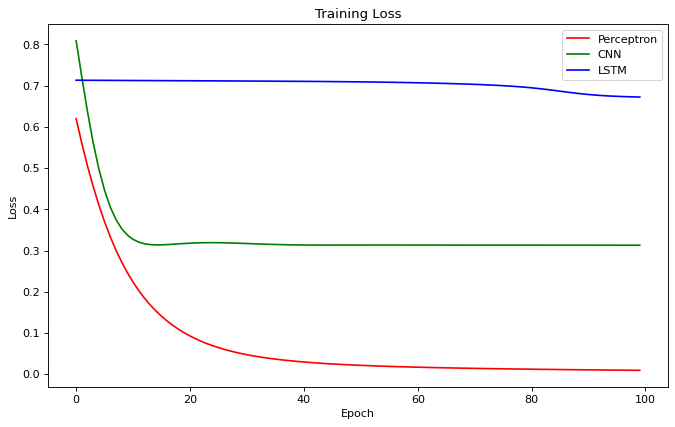

In [ ]:
#plotting the losses
loss1 = [i.detach().numpy() for i in loss1]
loss2 = [i.detach().numpy() for i in loss2]
loss3 = [i.detach().numpy() for i in loss3]

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(loss1, color='red',label='Perceptron')
plt.plot(loss2, color='green',label='CNN')
plt.plot(loss3, color='blue',label='LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
yp_per = [(1 if i > 0.5 else 0) for i in m1.evaluate(x)]
yp_cnn = [(1 if i > 0.5 else 0) for i in m2.evaluate(x)]
yp_lsm = [(1 if i > 0.5 else 0) for i in m3.evaluate(x)]
ye = y.squeeze().tolist()

In [10]:
def calc_accuracy(yp,ye):
    a = 0
    for i in range(len(yp)):
        if(yp[i]==ye[i]):
            a += 1
    a = a/len(yp)
    return a

print('Perceptron accuracy:', calc_accuracy(yp_per,ye))
print('CNN accuracy:', calc_accuracy(yp_cnn,ye))
print('LSTM accuracy:', calc_accuracy(yp_lsm,ye))

print('\n###Example Run##\n\nWith droupout average results:\nPerceptron accuracy: 1.0\nCNN accuracy: 1.0\nLSTM accuracy: 1.0\n\nWithout droupout average results:\nPerceptron accuracy: 1.0\nCNN accuracy: 1.0\nLSTM accuracy: 0.5')

Perceptron accuracy: 1.0
CNN accuracy: 1.0
LSTM accuracy: 1.0

###Example Run##

With droupout average results:
Perceptron accuracy: 1.0
CNN accuracy: 1.0
LSTM accuracy: 1.0

Without droupout average results:
Perceptron accuracy: 1.0
CNN accuracy: 1.0
LSTM accuracy: 0.5
